In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Tratamento de warning
import warnings
warnings.filterwarnings('ignore')

### ABRINDO DF APÓS EDA E TRATAMENTOS

In [3]:
%store -r datatran

In [4]:
df = datatran

In [5]:
df.columns

Index(['id', 'ano', 'feriado', 'mes', 'data_inversa', 'uf', 'br', 'km',
       'municipio', 'causa_acidente', 'classificacao_acidente', 'veiculos',
       'condicao_metereologica', 'fase_dia', 'dia_semana', 'tipo_acidente',
       'tipo_pista', 'mortos', 'feridos_graves', 'latitude', 'longitude',
       'status'],
      dtype='object')

### COM BASE MES, FERIADO, CLIMA, RODOVIA E UF -> SABER SE ESTRADA PERIGOSA OU NÃO -> RISCO
QUANDO BASE DE DADOS RECEBER NOVOS DADOS -> CLASSIFICAR

In [6]:
colunas_para_remover = ['id', 'ano', 'data_inversa', 'km', 'municipio', 'causa_acidente', 'classificacao_acidente', 'veiculos', 'dia_semana', 'tipo_acidente', 'tipo_pista', 'mortos', 'feridos_graves', 'latitude', 'longitude',]
df_model = df.drop(colunas_para_remover, axis=1)

In [7]:
rows, cols = df_model.shape
print(f'Linhas: {rows}. Colunas: {cols}')

Linhas: 163421. Colunas: 7


In [8]:
df_model.columns

Index(['feriado', 'mes', 'uf', 'br', 'condicao_metereologica', 'fase_dia',
       'status'],
      dtype='object')

### Mapa de correlacao entre variaveis
>- Analisar a correlacao das variaveis

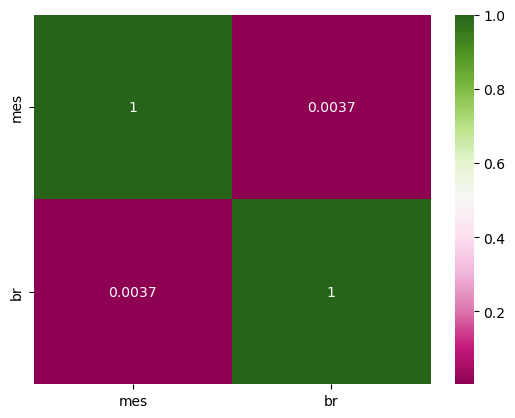

In [9]:
sns.heatmap(df_model[['feriado', 'mes', 'uf', 'br', 'condicao_metereologica', 'fase_dia', 'status']].corr(), annot=True, cmap="PiYG")
plt.show()

In [10]:
df_model.head(1)

,feriado,mes,uf,br,condicao_metereologica,fase_dia,status
0,y,1,ES,101,Céu Claro,Plena Noite,Segura


### Normalizando os dados

- Usar One-Hot Encoding: dados categóricos que não têm ordem


In [11]:
from sklearn.preprocessing import OneHotEncoder

# Aplicar One-Hot Encoding nas variáveis categóricas
categorical_cols = ['feriado', 'mes', 'uf', 'br','condicao_metereologica', 'fase_dia']
df_encoded = pd.get_dummies(df_model, columns=categorical_cols)

In [12]:
df_encoded.head(1)

,status,feriado_n,feriado_y,mes_1,mes_2,mes_3,mes_4,mes_5,mes_6,mes_7,...,condicao_metereologica_Granizo,condicao_metereologica_Neve,condicao_metereologica_Nevoeiro/Neblina,condicao_metereologica_Nublado,condicao_metereologica_Sol,condicao_metereologica_Vento,fase_dia_Amanhecer,fase_dia_Anoitecer,fase_dia_Plena Noite,fase_dia_Pleno dia
0,Segura,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


### Separando os dados em treino e teste

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [14]:
X = df_encoded.drop('status', axis=1)
y = df_encoded['status']

#### Equilibrando a target

In [15]:
y.value_counts(normalize=True)*100

Segura      71.847559
Perigosa    28.152441
Name: status, dtype: float64

In [16]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [17]:
y_resampled.value_counts(normalize=True)*100

Segura      50.0
Perigosa    50.0
Name: status, dtype: float64

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.25, random_state=42)

### GRID SEARCH para encontrar o melhor modelo e hiperparâmetros

- devido a problemas de performance, grid search simples para "simular" seu uso.

In [25]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

In [27]:
# Definir a validação cruzada estratificada
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Modelos e primeiros parâmetros para rápida avaliação
models_params = {
    'RandomForest': {
        'model': RandomForestClassifier(),
        'params': {'n_estimators': [50, 100], 'max_depth': [10, 20], 'class_weight': ['balanced']}
    },
    'GradientBoosting': {
        'model': GradientBoostingClassifier(),
        'params': {'n_estimators': [50, 100], 'learning_rate': [0.1, 0.2]}
    },
    'LogisticRegression': {
        'model': LogisticRegression(),
        'params': {'C': [0.1, 1], 'solver': ['lbfgs', 'liblinear']}
    }
}

# Executar GridSearchCV com validação cruzada
best_models = {}

for model_name, model_data in models_params.items():
    print(f"Treinando {model_name} com validação cruzada...")

    grid_search = GridSearchCV(model_data['model'], model_data['params'], cv=cv_strategy, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)  # Certifique-se de que 'X_train' e 'y_train' estão definidos

    scores = cross_val_score(grid_search.best_estimator_, X_train, y_train, cv=cv_strategy, scoring='accuracy')

    print(scores)
    print(f"Acurácia média com validação cruzada para {model_name}: {scores.mean():.4f}")

    best_models[model_name] = grid_search.best_estimator_
    print(f"Melhores parâmetros para {model_name}: {grid_search.best_params_}\n")

print("Modelos validados e prontos para refinamento.")

Treinando RandomForest com validação cruzada...
[0.61345635 0.61460936 0.61438224 0.61645469 0.61344538]
Acurácia média com validação cruzada para RandomForest: 0.6145
Melhores parâmetros para RandomForest: {'class_weight': 'balanced', 'max_depth': 20, 'n_estimators': 100}

Treinando GradientBoosting com validação cruzada...
[0.62191625 0.62698728 0.62312628 0.62494322 0.62465932]
Acurácia média com validação cruzada para GradientBoosting: 0.6243
Melhores parâmetros para GradientBoosting: {'learning_rate': 0.2, 'n_estimators': 100}

Treinando LogisticRegression com validação cruzada...
[0.63261888 0.63615717 0.63462412 0.63686691 0.63720759]
Acurácia média com validação cruzada para LogisticRegression: 0.6355
Melhores parâmetros para LogisticRegression: {'C': 1, 'solver': 'liblinear'}

Modelos validados e prontos para refinamento.


In [31]:
best_model_name = max(best_models, key=lambda model: cross_val_score(best_models[model], X_train, y_train, cv=cv_strategy, scoring='accuracy').mean())
best_model = best_models[best_model_name]

print(f"O melhor modelo é: {best_model_name}")

O melhor modelo é: LogisticRegression


In [32]:
y_pred = best_model.predict(X_test)

print(f"Previsões realizadas com {best_model_name}!")

Previsões realizadas com LogisticRegression!


In [33]:
from sklearn.metrics import accuracy_score, classification_report

print(f"Acurácia no conjunto de teste: {accuracy_score(y_test, y_pred):.4f}")
print("Relatório de classificação:")
print(classification_report(y_test, y_pred))


Acurácia no conjunto de teste: 0.6362
Relatório de classificação:
              precision    recall  f1-score   support

    Perigosa       0.68      0.52      0.59     29669
      Segura       0.61      0.75      0.67     29038

    accuracy                           0.64     58707
   macro avg       0.65      0.64      0.63     58707
weighted avg       0.65      0.64      0.63     58707



### Melhorando o modelo

In [35]:
param_grid = {
    'C': [0.1, 1, 10],  
    'solver': ['lbfgs', 'liblinear', 'saga'],  
    'max_iter': [100, 200, 500]
}

grid_search_refined = GridSearchCV(best_model, param_grid, cv=cv_strategy, scoring='accuracy', n_jobs=-1)
grid_search_refined.fit(X_train, y_train)

best_model = grid_search_refined.best_estimator_
print(f"Novos melhores parâmetros: {grid_search_refined.best_params_}")

Novos melhores parâmetros: {'C': 10, 'max_iter': 500, 'solver': 'lbfgs'}


In [41]:
from sklearn.preprocessing import LabelBinarizer

# Converter os rótulos categóricos em 0 e 1
lb = LabelBinarizer()
y_test_binary = lb.fit_transform(y_test).ravel()

# Agora, execute precision_recall_curve corretamente
precision, recall, thresholds = precision_recall_curve(y_test_binary, y_probs)

# Testar diferentes limiares
for threshold in thresholds:
    y_pred_threshold = (y_probs >= threshold).astype(int)
    print(f"Threshold {threshold:.2f}: Acurácia = {accuracy_score(y_test_binary, y_pred_threshold):.4f}")

Threshold 0.03: Acurácia = 0.5901
Threshold 0.04: Acurácia = 0.5901
Threshold 0.04: Acurácia = 0.5901
Threshold 0.05: Acurácia = 0.5902
Threshold 0.06: Acurácia = 0.5902
Threshold 0.07: Acurácia = 0.5902
Threshold 0.07: Acurácia = 0.5902
Threshold 0.08: Acurácia = 0.5902
Threshold 0.08: Acurácia = 0.5902
Threshold 0.08: Acurácia = 0.5903
Threshold 0.09: Acurácia = 0.5903
Threshold 0.09: Acurácia = 0.5903
Threshold 0.09: Acurácia = 0.5903
Threshold 0.10: Acurácia = 0.5903
Threshold 0.10: Acurácia = 0.5903
Threshold 0.10: Acurácia = 0.5904
Threshold 0.11: Acurácia = 0.5904
Threshold 0.12: Acurácia = 0.5904
Threshold 0.15: Acurácia = 0.5904
Threshold 0.15: Acurácia = 0.5904
Threshold 0.15: Acurácia = 0.5904
Threshold 0.17: Acurácia = 0.5905
Threshold 0.19: Acurácia = 0.5905
Threshold 0.20: Acurácia = 0.5905
Threshold 0.20: Acurácia = 0.5905
Threshold 0.21: Acurácia = 0.5905
Threshold 0.21: Acurácia = 0.5905
Threshold 0.23: Acurácia = 0.5906
Threshold 0.23: Acurácia = 0.5906
Threshold 0.23

              precision    recall  f1-score   support

    Perigosa       0.68      0.52      0.59     29669
      Segura       0.61      0.75      0.67     29038

    accuracy                           0.64     58707
   macro avg       0.64      0.64      0.63     58707
weighted avg       0.65      0.64      0.63     58707



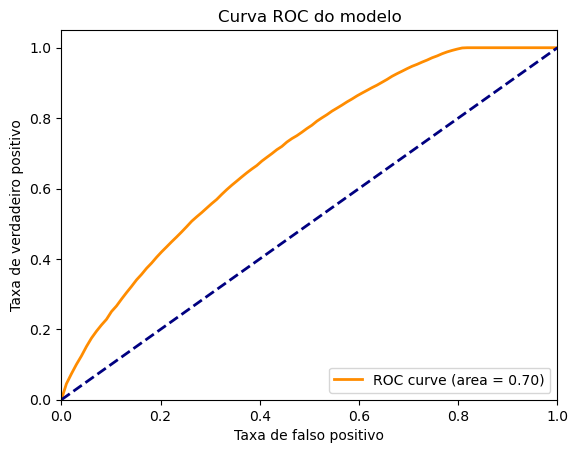

[[15526 14143]
 [ 7204 21834]]


In [42]:
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np


best_model.fit(X_train, y_train)

#y_pred = best_model.predict(X_test)

#print(classification_report(y_test, y_pred))

#fpr, tpr, thresholds = roc_curve(y_test, y_pred)
#roc_auc = auc(fpr, tpr)

y_pred_probs = best_model.predict_proba(X_test)[:, 1]  # Probabilidade da classe positiva
print(classification_report(y_test, y_pred))

fpr, tpr, thresholds = roc_curve(y_test_binary, y_pred_probs)
roc_auc = auc(fpr, tpr)


fpr_smooth = np.linspace(fpr[0], fpr[-1], 100)
tpr_smooth = np.interp(fpr_smooth, fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr_smooth, tpr_smooth, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de falso positivo')
plt.ylabel('Taxa de verdadeiro positivo')
plt.title('Curva ROC do modelo')
plt.legend(loc="lower right")
plt.show()

matriz = confusion_matrix(y_test, y_pred)
print(matriz)

In [46]:
y_pred = best_model.predict(X_test)

In [47]:
# 5 primeiras previsões das classes pelo modelo
print(y_pred[:5])

['Segura' 'Segura' 'Segura' 'Perigosa' 'Perigosa']


In [48]:
# 5 primeiras classes reais
print(y_test[:5])

46593     Perigosa
26886     Perigosa
871       Perigosa
95190       Segura
159388      Segura
Name: status, dtype: object


In [49]:
df_completo = X_test.copy()
df_completo['y_real'] = y_test
df_completo['y_predito'] = y_pred

In [50]:
df_completo.head(1)

,feriado_n,feriado_y,mes_1,mes_2,mes_3,mes_4,mes_5,mes_6,mes_7,mes_8,...,condicao_metereologica_Nevoeiro/Neblina,condicao_metereologica_Nublado,condicao_metereologica_Sol,condicao_metereologica_Vento,fase_dia_Amanhecer,fase_dia_Anoitecer,fase_dia_Plena Noite,fase_dia_Pleno dia,y_real,y_predito
46593,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,Perigosa,Segura


In [51]:
# Calculando métricas de desempenho (acurácia, precisão, revocação e F1-Score)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='micro')
recall = recall_score(y_test, y_pred, average='micro')
f1 = f1_score(y_test, y_pred, average='micro')

In [52]:
print("Acurácia:", accuracy)
print("Precisão:", precision)
print("Revocação:", recall)
print("F1-Score:", f1)

Acurácia: 0.6363806701074829
Precisão: 0.6363806701074829
Revocação: 0.6363806701074829
F1-Score: 0.6363806701074829


### Fazendo previsões com o modelo treinado

In [58]:
# Criando novos dados fictícios
df_novo = pd.DataFrame({
    'feriado': ['n', 'y', 'n', 'y', 'n'],
    'mes': [2, 5, 8, 11, 12],
    'uf': ['SP', 'RJ', 'MG', 'BA', 'PR'],
    'br': [150, 200, 310, 420, 500],
    'condicao_metereologica': ['Chuva', 'Nublado', 'Nevoeiro', 'Sol forte', 'Céu Claro'],
    'fase_dia': ['Manhã', 'Tarde', 'Anoitecer', 'Madrugada', 'Plena Noite']
})

print(df_novo)

  feriado  mes  uf   br condicao_metereologica     fase_dia
0       n    2  SP  150                  Chuva        Manhã
1       y    5  RJ  200                Nublado        Tarde
2       n    8  MG  310               Nevoeiro    Anoitecer
3       y   11  BA  420              Sol forte    Madrugada
4       n   12  PR  500              Céu Claro  Plena Noite


### Normalizando os dados novos

In [66]:
# Aplicar One-Hot Encoding nos novos dados
df_novo_encoded = pd.get_dummies(df_novo, columns=categorical_cols)

# Adicionar colunas que faltam para igualar ao modelo treinado
missing_cols = set(df_encoded.columns) - set(df_novo_encoded.columns)
for col in missing_cols:
    df_novo_encoded[col] = 0  # Adiciona colunas ausentes com zero

# Garantir que as colunas estão na mesma ordem
df_novo_encoded = df_novo_encoded[df_encoded.columns]
X_novo = df_novo_encoded.drop('status', axis=1)

print("Agora os novos dados têm as mesmas colunas que o treino!")

Agora os novos dados têm as mesmas colunas que o treino!


In [68]:
X_novo

,feriado_n,feriado_y,mes_1,mes_2,mes_3,mes_4,mes_5,mes_6,mes_7,mes_8,...,condicao_metereologica_Granizo,condicao_metereologica_Neve,condicao_metereologica_Nevoeiro/Neblina,condicao_metereologica_Nublado,condicao_metereologica_Sol,condicao_metereologica_Vento,fase_dia_Amanhecer,fase_dia_Anoitecer,fase_dia_Plena Noite,fase_dia_Pleno dia
0,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [69]:
y_novo_pred = best_model.predict(X_novo)
print("Novas previsões:", y_novo_pred)


Novas previsões: ['Segura' 'Segura' 'Segura' 'Segura' 'Segura']


In [70]:
y_novo_probs = best_model.predict_proba(X_novo)
print("Probabilidades de previsão:", y_novo_probs)


Probabilidades de previsão: [[0.00366316 0.99633684]
 [0.00309289 0.99690711]
 [0.00624519 0.99375481]
 [0.00346173 0.99653827]
 [0.12913952 0.87086048]]


### SALVANDO O MODELO

In [71]:
import joblib

# Salvar o modelo treinado
joblib.dump(best_model, 'modelo_treinado.pkl')

['modelo_treinado.pkl']

In [ ]:
# Carregar o modelo salvo e fazer previsões
modelo_carregado = joblib.load('./resultados/modelo_treinado.pkl')
y_novo_pred = modelo_carregado.predict(X_novo)
print("Previsões do modelo carregado:", y_novo_pred)

Previsões do modelo carregado: ['Segura' 'Segura' 'Segura' 'Segura' 'Segura']
